In [1]:
from tf_activation.models import mnist_cff as mnist_model
from tf_activation.experiments import distance_finder

from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
persistence_module = tf.load_op_library('/home/tgebhart/python/tensorflow/bazel-bin/tensorflow/core/user_ops/nn_graph_persistence.so')

from time import time
import os

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
SAVE_PATH = '../logdir/models'
model = 'mnist_cff_2000.ckpt'
p = 95

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.log_device_placement = True

In [3]:
# kmeans = KMeans(init='k-means++', n_clusters=len(mnist.train.labels[0]), n_init=10)
# kmeans.fit(mnist.train.images)
# joblib.dump(kmeans, os.path.join(SAVE_PATH, 'kmeans.pkl'))
kmeans = joblib.load(os.path.join(SAVE_PATH, 'kmeans.pkl'))

In [4]:
df = []
centers = kmeans.cluster_centers_

with tf.device('/cpu:0'):
        # Create the model
        x = tf.placeholder(tf.float32, [None, 784])

        # Define loss and optimizer
        y_ = tf.placeholder(tf.float32, [None, 10])

        # Build the graph for the deep net
        net, keep_prob = mnist_model.deepnn(x)

        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=net['y_conv']))
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
        correct_prediction = tf.equal(tf.argmax(net['y_conv'], 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver()
        
with tf.Session(config=config) as sess:

    saver.restore(sess, os.path.join(SAVE_PATH, model))

    for i in range(mnist.train.images.shape[0]):
        col = {}
        s = kmeans.score(mnist.train.images[i].reshape(1,-1))
        c = centers[kmeans.predict(mnist.train.images[i].reshape(1,-1))][0,:]
        d = np.linalg.norm(c - mnist.train.images[i])
        col['score'] = s
        col['distance'] = d
    
        test_inputs = np.stack((mnist.train.images[i], c))
        test_labels = np.stack((mnist.train.labels[i], mnist.train.labels[i]))

        percentiles = persistence_module.layerwise_percentile([net['input'],
                                                            net['W_conv1'],
                                                            net['h_conv1'],
                                                            net['h_conv1'],
                                                            net['W_fc1'],
                                                            net['h_fc1'],
                                                            net['h_fc1_drop'],
                                                            net['W_fc2'],
                                                            net['y_conv']],
                                                            [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                            [p,p,p])

        ps1 = percentiles.eval(feed_dict={x: test_inputs[0:1], keep_prob:1.0})
        ps2 = percentiles.eval(feed_dict={x: test_inputs[1:2], keep_prob:1.0})

        result = persistence_module.wasserstein_distance([net['input'],
                                                            net['W_conv1'],
                                                            net['h_conv1'],
                                                            net['h_conv1'],
                                                            net['W_fc1'],
                                                            net['h_fc1'],
                                                            net['h_fc1_drop'],
                                                            net['W_fc2'],
                                                            net['y_conv']],
                                                            [0, 1, 2, 2, 1, 4, 4, 1, 4],
                                                            np.stack((ps1, ps2))
                                                            )

        per_distance = result.eval(feed_dict={x: test_inputs, keep_prob:1.0})
        print('Test Image: {}, Persistence Distance: {}'.format(i, per_distance))

        ce = cross_entropy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1.0})
        y_conv = sess.run(net['y_conv'], feed_dict={x:test_inputs[1:], keep_prob:1.0})
        acc = accuracy.eval(feed_dict={x:test_inputs[1:], y_:test_labels[1:], keep_prob:1})
        y_conv = y_conv / np.linalg.norm(y_conv)
        
        col['per_distance'] = per_distance[0]
        col['cross_entropy'] = ce
        col['y_conv'] = y_conv[0,np.argmax(test_labels[1], axis=0)]
        col['accuracy'] = acc
        
        df.append(col)

INFO:tensorflow:Restoring parameters from ../logdir/models/mnist_cff_2000.ckpt
Test Image: 0, Persistence Distance: [ 2637040.]
Test Image: 1, Persistence Distance: [ 3096548.]
Test Image: 2, Persistence Distance: [ 3589674.75]
Test Image: 3, Persistence Distance: [ 3711570.]
Test Image: 4, Persistence Distance: [ 3168320.25]
Test Image: 5, Persistence Distance: [ 2825887.5]
Test Image: 6, Persistence Distance: [ 2667565.]
Test Image: 7, Persistence Distance: [ 2504482.75]
Test Image: 8, Persistence Distance: [ 3950360.25]
Test Image: 9, Persistence Distance: [ 2907510.5]
Test Image: 10, Persistence Distance: [ 3259613.25]
Test Image: 11, Persistence Distance: [ 3318186.25]
Test Image: 12, Persistence Distance: [ 3719189.]
Test Image: 13, Persistence Distance: [ 3125635.25]
Test Image: 14, Persistence Distance: [ 3794294.]
Test Image: 15, Persistence Distance: [ 2290140.]
Test Image: 16, Persistence Distance: [ 3520227.5]
Test Image: 17, Persistence Distance: [ 1878587.75]
Test Image: 

Test Image: 158, Persistence Distance: [ 3588967.75]
Test Image: 159, Persistence Distance: [ 1362128.375]
Test Image: 160, Persistence Distance: [ 3935497.75]
Test Image: 161, Persistence Distance: [ 2590856.5]
Test Image: 162, Persistence Distance: [ 3311226.25]
Test Image: 163, Persistence Distance: [ 2441937.25]
Test Image: 164, Persistence Distance: [ 3759852.75]
Test Image: 165, Persistence Distance: [ 2310552.]
Test Image: 166, Persistence Distance: [ 3462356.75]
Test Image: 167, Persistence Distance: [ 1897333.125]
Test Image: 168, Persistence Distance: [ 3152147.75]
Test Image: 169, Persistence Distance: [ 2326611.5]
Test Image: 170, Persistence Distance: [ 3282019.75]
Test Image: 171, Persistence Distance: [ 3258486.75]
Test Image: 172, Persistence Distance: [ 3491485.25]
Test Image: 173, Persistence Distance: [ 3283562.5]
Test Image: 174, Persistence Distance: [ 2482070.5]
Test Image: 175, Persistence Distance: [ 2732306.25]
Test Image: 176, Persistence Distance: [ 3056373.7

Test Image: 315, Persistence Distance: [ 3072946.]
Test Image: 316, Persistence Distance: [ 3522310.25]
Test Image: 317, Persistence Distance: [ 2783214.25]
Test Image: 318, Persistence Distance: [ 2712684.]
Test Image: 319, Persistence Distance: [ 1839641.]
Test Image: 320, Persistence Distance: [ 3334157.]
Test Image: 321, Persistence Distance: [ 2320547.25]
Test Image: 322, Persistence Distance: [ 4088069.5]
Test Image: 323, Persistence Distance: [ 2354481.5]
Test Image: 324, Persistence Distance: [ 2975740.25]
Test Image: 325, Persistence Distance: [ 3216991.75]
Test Image: 326, Persistence Distance: [ 3474955.5]
Test Image: 327, Persistence Distance: [ 3563160.75]
Test Image: 328, Persistence Distance: [ 3879058.5]
Test Image: 329, Persistence Distance: [ 2479217.25]
Test Image: 330, Persistence Distance: [ 3761385.75]
Test Image: 331, Persistence Distance: [ 2059621.375]
Test Image: 332, Persistence Distance: [ 3497085.5]
Test Image: 333, Persistence Distance: [ 3244108.25]
Test 

Test Image: 472, Persistence Distance: [ 2906701.]
Test Image: 473, Persistence Distance: [ 2576807.]
Test Image: 474, Persistence Distance: [ 2370813.25]
Test Image: 475, Persistence Distance: [ 2100595.25]
Test Image: 476, Persistence Distance: [ 4305251.]
Test Image: 477, Persistence Distance: [ 2770842.75]
Test Image: 478, Persistence Distance: [ 2236798.5]
Test Image: 479, Persistence Distance: [ 2940380.25]
Test Image: 480, Persistence Distance: [ 3535108.]
Test Image: 481, Persistence Distance: [ 2128663.75]
Test Image: 482, Persistence Distance: [ 3589379.75]
Test Image: 483, Persistence Distance: [ 2942285.25]
Test Image: 484, Persistence Distance: [ 2804656.]
Test Image: 485, Persistence Distance: [ 3343315.]
Test Image: 486, Persistence Distance: [ 3394586.75]
Test Image: 487, Persistence Distance: [ 2948504.75]
Test Image: 488, Persistence Distance: [ 2296290.75]
Test Image: 489, Persistence Distance: [ 3509249.75]
Test Image: 490, Persistence Distance: [ 3041330.25]
Test I

Test Image: 629, Persistence Distance: [ 2035850.5]
Test Image: 630, Persistence Distance: [ 3584221.5]
Test Image: 631, Persistence Distance: [ 3030435.75]
Test Image: 632, Persistence Distance: [ 3183441.]
Test Image: 633, Persistence Distance: [ 2446906.5]
Test Image: 634, Persistence Distance: [ 2403523.5]
Test Image: 635, Persistence Distance: [ 2925262.5]
Test Image: 636, Persistence Distance: [ 2712340.5]
Test Image: 637, Persistence Distance: [ 3571792.75]
Test Image: 638, Persistence Distance: [ 3245810.75]
Test Image: 639, Persistence Distance: [ 3176702.25]
Test Image: 640, Persistence Distance: [ 2848056.25]
Test Image: 641, Persistence Distance: [ 3280126.25]
Test Image: 642, Persistence Distance: [ 3469789.5]
Test Image: 643, Persistence Distance: [ 2908818.25]
Test Image: 644, Persistence Distance: [ 3444871.5]
Test Image: 645, Persistence Distance: [ 2889855.5]
Test Image: 646, Persistence Distance: [ 3664228.]
Test Image: 647, Persistence Distance: [ 3200110.5]
Test Im

Test Image: 786, Persistence Distance: [ 4193421.5]
Test Image: 787, Persistence Distance: [ 3112968.]
Test Image: 788, Persistence Distance: [ 3949315.5]
Test Image: 789, Persistence Distance: [ 3095756.]
Test Image: 790, Persistence Distance: [ 3734663.]
Test Image: 791, Persistence Distance: [ 3584436.25]
Test Image: 792, Persistence Distance: [ 4183238.]
Test Image: 793, Persistence Distance: [ 3403894.75]
Test Image: 794, Persistence Distance: [ 4104457.]
Test Image: 795, Persistence Distance: [ 2552526.]
Test Image: 796, Persistence Distance: [ 3352194.25]
Test Image: 797, Persistence Distance: [ 2585976.25]
Test Image: 798, Persistence Distance: [ 2840018.5]
Test Image: 799, Persistence Distance: [ 3541704.75]
Test Image: 800, Persistence Distance: [ 3135308.5]
Test Image: 801, Persistence Distance: [ 2753434.75]
Test Image: 802, Persistence Distance: [ 2486490.25]
Test Image: 803, Persistence Distance: [ 3501345.75]
Test Image: 804, Persistence Distance: [ 3245846.5]
Test Image

Test Image: 944, Persistence Distance: [ 3891988.5]
Test Image: 945, Persistence Distance: [ 3645044.25]
Test Image: 946, Persistence Distance: [ 3327540.75]
Test Image: 947, Persistence Distance: [ 3537929.75]
Test Image: 948, Persistence Distance: [ 2911091.75]
Test Image: 949, Persistence Distance: [ 2593282.25]
Test Image: 950, Persistence Distance: [ 3281408.]
Test Image: 951, Persistence Distance: [ 1945576.125]
Test Image: 952, Persistence Distance: [ 2330339.25]
Test Image: 953, Persistence Distance: [ 3132569.5]
Test Image: 954, Persistence Distance: [ 3446804.]
Test Image: 955, Persistence Distance: [ 3003259.]
Test Image: 956, Persistence Distance: [ 3673072.]
Test Image: 957, Persistence Distance: [ 3113876.5]
Test Image: 958, Persistence Distance: [ 3767264.75]
Test Image: 959, Persistence Distance: [ 2671674.75]
Test Image: 960, Persistence Distance: [ 3783249.25]
Test Image: 961, Persistence Distance: [ 2387422.5]
Test Image: 962, Persistence Distance: [ 2398882.75]
Test

Test Image: 1099, Persistence Distance: [ 2629206.25]
Test Image: 1100, Persistence Distance: [ 3342365.]
Test Image: 1101, Persistence Distance: [ 2005572.375]
Test Image: 1102, Persistence Distance: [ 3532806.75]
Test Image: 1103, Persistence Distance: [ 2993762.5]
Test Image: 1104, Persistence Distance: [ 3244160.25]
Test Image: 1105, Persistence Distance: [ 3024891.5]
Test Image: 1106, Persistence Distance: [ 3859020.5]
Test Image: 1107, Persistence Distance: [ 3436983.]
Test Image: 1108, Persistence Distance: [ 3941412.25]
Test Image: 1109, Persistence Distance: [ 2589804.75]
Test Image: 1110, Persistence Distance: [ 3624105.25]
Test Image: 1111, Persistence Distance: [ 3425984.75]
Test Image: 1112, Persistence Distance: [ 2945673.5]
Test Image: 1113, Persistence Distance: [ 3015729.75]
Test Image: 1114, Persistence Distance: [ 2762763.75]
Test Image: 1115, Persistence Distance: [ 2503207.25]
Test Image: 1116, Persistence Distance: [ 3091179.]
Test Image: 1117, Persistence Distanc

Test Image: 1253, Persistence Distance: [ 2486890.]
Test Image: 1254, Persistence Distance: [ 3248444.5]
Test Image: 1255, Persistence Distance: [ 3298510.75]
Test Image: 1256, Persistence Distance: [ 2854048.75]
Test Image: 1257, Persistence Distance: [ 2653595.25]
Test Image: 1258, Persistence Distance: [ 3285064.25]
Test Image: 1259, Persistence Distance: [ 3189180.5]
Test Image: 1260, Persistence Distance: [ 2330144.75]
Test Image: 1261, Persistence Distance: [ 2769227.25]
Test Image: 1262, Persistence Distance: [ 3716615.5]
Test Image: 1263, Persistence Distance: [ 3392793.5]
Test Image: 1264, Persistence Distance: [ 4478303.5]
Test Image: 1265, Persistence Distance: [ 3050046.]
Test Image: 1266, Persistence Distance: [ 2709075.]
Test Image: 1267, Persistence Distance: [ 3002425.75]
Test Image: 1268, Persistence Distance: [ 3877047.25]
Test Image: 1269, Persistence Distance: [ 2842943.]
Test Image: 1270, Persistence Distance: [ 1257919.375]
Test Image: 1271, Persistence Distance: 

Test Image: 1407, Persistence Distance: [ 2960564.25]
Test Image: 1408, Persistence Distance: [ 2859558.5]
Test Image: 1409, Persistence Distance: [ 2414157.5]
Test Image: 1410, Persistence Distance: [ 3324495.75]
Test Image: 1411, Persistence Distance: [ 3048246.5]
Test Image: 1412, Persistence Distance: [ 3548204.25]
Test Image: 1413, Persistence Distance: [ 2924396.75]
Test Image: 1414, Persistence Distance: [ 3537143.]
Test Image: 1415, Persistence Distance: [ 3590650.5]
Test Image: 1416, Persistence Distance: [ 2996896.]
Test Image: 1417, Persistence Distance: [ 3069703.]
Test Image: 1418, Persistence Distance: [ 3686807.75]
Test Image: 1419, Persistence Distance: [ 3183178.]
Test Image: 1420, Persistence Distance: [ 3869473.25]
Test Image: 1421, Persistence Distance: [ 3247153.75]
Test Image: 1422, Persistence Distance: [ 4097281.25]
Test Image: 1423, Persistence Distance: [ 2743125.75]
Test Image: 1424, Persistence Distance: [ 3785443.25]
Test Image: 1425, Persistence Distance: 

Test Image: 1561, Persistence Distance: [ 2774923.75]
Test Image: 1562, Persistence Distance: [ 3766573.25]
Test Image: 1563, Persistence Distance: [ 4040530.]
Test Image: 1564, Persistence Distance: [ 3147105.25]
Test Image: 1565, Persistence Distance: [ 3336548.5]
Test Image: 1566, Persistence Distance: [ 3982740.25]
Test Image: 1567, Persistence Distance: [ 3158155.25]
Test Image: 1568, Persistence Distance: [ 3849994.5]
Test Image: 1569, Persistence Distance: [ 2975935.25]
Test Image: 1570, Persistence Distance: [ 3064272.5]
Test Image: 1571, Persistence Distance: [ 3099283.5]
Test Image: 1572, Persistence Distance: [ 3593062.]
Test Image: 1573, Persistence Distance: [ 3483229.75]
Test Image: 1574, Persistence Distance: [ 3325109.75]
Test Image: 1575, Persistence Distance: [ 2751220.25]
Test Image: 1576, Persistence Distance: [ 3691091.]
Test Image: 1577, Persistence Distance: [ 3298497.75]
Test Image: 1578, Persistence Distance: [ 3522787.]
Test Image: 1579, Persistence Distance: 

Test Image: 1715, Persistence Distance: [ 4341639.]
Test Image: 1716, Persistence Distance: [ 3596829.75]
Test Image: 1717, Persistence Distance: [ 4266869.]
Test Image: 1718, Persistence Distance: [ 2827493.25]
Test Image: 1719, Persistence Distance: [ 4239692.5]
Test Image: 1720, Persistence Distance: [ 3522966.75]
Test Image: 1721, Persistence Distance: [ 3702805.25]
Test Image: 1722, Persistence Distance: [ 3913196.]
Test Image: 1723, Persistence Distance: [ 4568363.]
Test Image: 1724, Persistence Distance: [ 2935855.]
Test Image: 1725, Persistence Distance: [ 2263837.]
Test Image: 1726, Persistence Distance: [ 3673146.]
Test Image: 1727, Persistence Distance: [ 4424385.5]
Test Image: 1728, Persistence Distance: [ 3747073.]
Test Image: 1729, Persistence Distance: [ 3683633.25]
Test Image: 1730, Persistence Distance: [ 4543089.5]
Test Image: 1731, Persistence Distance: [ 4427453.5]
Test Image: 1732, Persistence Distance: [ 2433171.5]
Test Image: 1733, Persistence Distance: [ 4253634

Test Image: 1870, Persistence Distance: [ 3092638.]
Test Image: 1871, Persistence Distance: [ 3452563.5]
Test Image: 1872, Persistence Distance: [ 3240779.5]
Test Image: 1873, Persistence Distance: [ 2834519.75]
Test Image: 1874, Persistence Distance: [ 3306378.5]
Test Image: 1875, Persistence Distance: [ 2347731.5]
Test Image: 1876, Persistence Distance: [ 4022226.75]
Test Image: 1877, Persistence Distance: [ 2880588.5]
Test Image: 1878, Persistence Distance: [ 3623252.75]
Test Image: 1879, Persistence Distance: [ 3862062.5]
Test Image: 1880, Persistence Distance: [ 2973807.]
Test Image: 1881, Persistence Distance: [ 3105721.75]
Test Image: 1882, Persistence Distance: [ 2603986.5]
Test Image: 1883, Persistence Distance: [ 2727396.25]
Test Image: 1884, Persistence Distance: [ 3035810.]
Test Image: 1885, Persistence Distance: [ 3742882.]
Test Image: 1886, Persistence Distance: [ 3808444.5]
Test Image: 1887, Persistence Distance: [ 2578126.]
Test Image: 1888, Persistence Distance: [ 3734

Test Image: 2024, Persistence Distance: [ 3733133.]
Test Image: 2025, Persistence Distance: [ 2573917.25]
Test Image: 2026, Persistence Distance: [ 4077815.]
Test Image: 2027, Persistence Distance: [ 3209196.25]
Test Image: 2028, Persistence Distance: [ 3391961.25]
Test Image: 2029, Persistence Distance: [ 2659593.75]
Test Image: 2030, Persistence Distance: [ 2580106.5]
Test Image: 2031, Persistence Distance: [ 3061497.25]
Test Image: 2032, Persistence Distance: [ 3948390.25]
Test Image: 2033, Persistence Distance: [ 2747489.75]
Test Image: 2034, Persistence Distance: [ 2554295.]
Test Image: 2035, Persistence Distance: [ 4088384.75]
Test Image: 2036, Persistence Distance: [ 3934806.25]
Test Image: 2037, Persistence Distance: [ 3149148.]
Test Image: 2038, Persistence Distance: [ 2052263.]
Test Image: 2039, Persistence Distance: [ 3185409.75]
Test Image: 2040, Persistence Distance: [ 2671984.75]
Test Image: 2041, Persistence Distance: [ 2852360.75]
Test Image: 2042, Persistence Distance:

Test Image: 2178, Persistence Distance: [ 3584153.75]
Test Image: 2179, Persistence Distance: [ 2297314.5]
Test Image: 2180, Persistence Distance: [ 3534131.]
Test Image: 2181, Persistence Distance: [ 3466056.]
Test Image: 2182, Persistence Distance: [ 4073884.25]
Test Image: 2183, Persistence Distance: [ 3336072.75]
Test Image: 2184, Persistence Distance: [ 3433110.5]
Test Image: 2185, Persistence Distance: [ 3429764.5]
Test Image: 2186, Persistence Distance: [ 3997304.5]
Test Image: 2187, Persistence Distance: [ 2840379.5]
Test Image: 2188, Persistence Distance: [ 3188289.25]
Test Image: 2189, Persistence Distance: [ 2602363.5]
Test Image: 2190, Persistence Distance: [ 2945904.5]
Test Image: 2191, Persistence Distance: [ 4074442.25]
Test Image: 2192, Persistence Distance: [ 3954734.]
Test Image: 2193, Persistence Distance: [ 4483117.]
Test Image: 2194, Persistence Distance: [ 3011056.5]
Test Image: 2195, Persistence Distance: [ 3078794.75]
Test Image: 2196, Persistence Distance: [ 40

Test Image: 2333, Persistence Distance: [ 4194801.5]
Test Image: 2334, Persistence Distance: [ 3100446.]
Test Image: 2335, Persistence Distance: [ 4182849.5]
Test Image: 2336, Persistence Distance: [ 4291761.]
Test Image: 2337, Persistence Distance: [ 4040302.]
Test Image: 2338, Persistence Distance: [ 2998616.25]
Test Image: 2339, Persistence Distance: [ 4427960.]
Test Image: 2340, Persistence Distance: [ 3437448.25]
Test Image: 2341, Persistence Distance: [ 3667680.25]
Test Image: 2342, Persistence Distance: [ 2627411.]
Test Image: 2343, Persistence Distance: [ 4135841.75]
Test Image: 2344, Persistence Distance: [ 4232051.5]
Test Image: 2345, Persistence Distance: [ 4033715.25]
Test Image: 2346, Persistence Distance: [ 4215451.]
Test Image: 2347, Persistence Distance: [ 3526742.75]
Test Image: 2348, Persistence Distance: [ 4192535.5]
Test Image: 2349, Persistence Distance: [ 3652170.]
Test Image: 2350, Persistence Distance: [ 3503952.5]
Test Image: 2351, Persistence Distance: [ 38076

Test Image: 2488, Persistence Distance: [ 4442353.]
Test Image: 2489, Persistence Distance: [ 4082061.25]
Test Image: 2490, Persistence Distance: [ 1846380.]
Test Image: 2491, Persistence Distance: [ 3716386.]
Test Image: 2492, Persistence Distance: [ 3974433.25]
Test Image: 2493, Persistence Distance: [ 3704871.5]
Test Image: 2494, Persistence Distance: [ 4111351.]
Test Image: 2495, Persistence Distance: [ 3673371.75]
Test Image: 2496, Persistence Distance: [ 3274368.25]
Test Image: 2497, Persistence Distance: [ 3314594.]
Test Image: 2498, Persistence Distance: [ 2480913.5]
Test Image: 2499, Persistence Distance: [ 4183988.25]
Test Image: 2500, Persistence Distance: [ 3233299.25]
Test Image: 2501, Persistence Distance: [ 3522503.]
Test Image: 2502, Persistence Distance: [ 3670484.75]
Test Image: 2503, Persistence Distance: [ 3739815.5]
Test Image: 2504, Persistence Distance: [ 2758928.25]
Test Image: 2505, Persistence Distance: [ 4244151.]
Test Image: 2506, Persistence Distance: [ 356

Test Image: 2643, Persistence Distance: [ 2537127.5]
Test Image: 2644, Persistence Distance: [ 2116486.75]
Test Image: 2645, Persistence Distance: [ 2953881.75]
Test Image: 2646, Persistence Distance: [ 3317338.25]
Test Image: 2647, Persistence Distance: [ 1771119.375]
Test Image: 2648, Persistence Distance: [ 3810722.25]
Test Image: 2649, Persistence Distance: [ 2775456.75]
Test Image: 2650, Persistence Distance: [ 3654116.5]
Test Image: 2651, Persistence Distance: [ 2350202.75]
Test Image: 2652, Persistence Distance: [ 4059731.]
Test Image: 2653, Persistence Distance: [ 3095403.5]
Test Image: 2654, Persistence Distance: [ 2455897.5]
Test Image: 2655, Persistence Distance: [ 3197990.75]
Test Image: 2656, Persistence Distance: [ 3776932.]
Test Image: 2657, Persistence Distance: [ 3933973.75]
Test Image: 2658, Persistence Distance: [ 2796657.]
Test Image: 2659, Persistence Distance: [ 2661612.5]
Test Image: 2660, Persistence Distance: [ 4028692.25]
Test Image: 2661, Persistence Distance

Test Image: 2797, Persistence Distance: [ 1271690.125]
Test Image: 2798, Persistence Distance: [ 4329242.]
Test Image: 2799, Persistence Distance: [ 2499297.5]
Test Image: 2800, Persistence Distance: [ 3673678.25]
Test Image: 2801, Persistence Distance: [ 3024861.]
Test Image: 2802, Persistence Distance: [ 2808153.]
Test Image: 2803, Persistence Distance: [ 3460228.5]
Test Image: 2804, Persistence Distance: [ 3323615.75]
Test Image: 2805, Persistence Distance: [ 2657923.75]
Test Image: 2806, Persistence Distance: [ 3189098.5]
Test Image: 2807, Persistence Distance: [ 3848228.]
Test Image: 2808, Persistence Distance: [ 3993448.25]
Test Image: 2809, Persistence Distance: [ 3339339.5]
Test Image: 2810, Persistence Distance: [ 3899338.5]
Test Image: 2811, Persistence Distance: [ 3250365.]
Test Image: 2812, Persistence Distance: [ 3265210.]
Test Image: 2813, Persistence Distance: [ 2171332.5]
Test Image: 2814, Persistence Distance: [ 3522433.25]
Test Image: 2815, Persistence Distance: [ 350

Test Image: 2951, Persistence Distance: [ 2710234.]
Test Image: 2952, Persistence Distance: [ 3423761.25]
Test Image: 2953, Persistence Distance: [ 2412959.5]
Test Image: 2954, Persistence Distance: [ 3610905.5]
Test Image: 2955, Persistence Distance: [ 3105077.25]
Test Image: 2956, Persistence Distance: [ 3740447.75]
Test Image: 2957, Persistence Distance: [ 3174901.5]
Test Image: 2958, Persistence Distance: [ 4368768.5]
Test Image: 2959, Persistence Distance: [ 3397124.25]
Test Image: 2960, Persistence Distance: [ 2652428.25]
Test Image: 2961, Persistence Distance: [ 3830399.25]
Test Image: 2962, Persistence Distance: [ 2705642.5]
Test Image: 2963, Persistence Distance: [ 2804955.75]
Test Image: 2964, Persistence Distance: [ 3535305.5]
Test Image: 2965, Persistence Distance: [ 2656848.5]
Test Image: 2966, Persistence Distance: [ 3010629.75]
Test Image: 2967, Persistence Distance: [ 3310688.25]
Test Image: 2968, Persistence Distance: [ 2652414.5]
Test Image: 2969, Persistence Distance

Test Image: 3105, Persistence Distance: [ 3666608.25]
Test Image: 3106, Persistence Distance: [ 3168381.25]
Test Image: 3107, Persistence Distance: [ 3509826.75]
Test Image: 3108, Persistence Distance: [ 2292479.25]
Test Image: 3109, Persistence Distance: [ 2984166.25]
Test Image: 3110, Persistence Distance: [ 3684076.]
Test Image: 3111, Persistence Distance: [ 3773975.75]
Test Image: 3112, Persistence Distance: [ 3040998.25]
Test Image: 3113, Persistence Distance: [ 2585321.75]
Test Image: 3114, Persistence Distance: [ 3843776.5]
Test Image: 3115, Persistence Distance: [ 3260319.]
Test Image: 3116, Persistence Distance: [ 2647322.5]
Test Image: 3117, Persistence Distance: [ 3780386.5]
Test Image: 3118, Persistence Distance: [ 3654066.75]
Test Image: 3119, Persistence Distance: [ 3041558.]
Test Image: 3120, Persistence Distance: [ 4403189.5]
Test Image: 3121, Persistence Distance: [ 3568591.]
Test Image: 3122, Persistence Distance: [ 3528552.5]
Test Image: 3123, Persistence Distance: [

Test Image: 3259, Persistence Distance: [ 1364343.875]
Test Image: 3260, Persistence Distance: [ 3354929.]
Test Image: 3261, Persistence Distance: [ 3104225.25]
Test Image: 3262, Persistence Distance: [ 3970156.]
Test Image: 3263, Persistence Distance: [ 3278314.]
Test Image: 3264, Persistence Distance: [ 3477126.]
Test Image: 3265, Persistence Distance: [ 3520518.75]
Test Image: 3266, Persistence Distance: [ 3288634.25]
Test Image: 3267, Persistence Distance: [ 1957094.875]
Test Image: 3268, Persistence Distance: [ 3246636.5]
Test Image: 3269, Persistence Distance: [ 3400283.75]
Test Image: 3270, Persistence Distance: [ 3287765.]
Test Image: 3271, Persistence Distance: [ 3738317.]
Test Image: 3272, Persistence Distance: [ 3124618.75]
Test Image: 3273, Persistence Distance: [ 2995447.75]
Test Image: 3274, Persistence Distance: [ 3099374.25]
Test Image: 3275, Persistence Distance: [ 1894216.75]
Test Image: 3276, Persistence Distance: [ 2620776.25]
Test Image: 3277, Persistence Distance:

Test Image: 3413, Persistence Distance: [ 2223822.75]
Test Image: 3414, Persistence Distance: [ 3659589.25]
Test Image: 3415, Persistence Distance: [ 2610457.75]
Test Image: 3416, Persistence Distance: [ 3912395.75]
Test Image: 3417, Persistence Distance: [ 2104251.25]
Test Image: 3418, Persistence Distance: [ 3397224.25]
Test Image: 3419, Persistence Distance: [ 2342399.25]
Test Image: 3420, Persistence Distance: [ 3938289.75]
Test Image: 3421, Persistence Distance: [ 4365211.]
Test Image: 3422, Persistence Distance: [ 3675852.]
Test Image: 3423, Persistence Distance: [ 2859822.25]
Test Image: 3424, Persistence Distance: [ 4188796.25]
Test Image: 3425, Persistence Distance: [ 1142957.5]
Test Image: 3426, Persistence Distance: [ 2909814.5]
Test Image: 3427, Persistence Distance: [ 2740079.5]
Test Image: 3428, Persistence Distance: [ 3113096.5]
Test Image: 3429, Persistence Distance: [ 2549855.75]
Test Image: 3430, Persistence Distance: [ 3297425.5]
Test Image: 3431, Persistence Distanc

Test Image: 3567, Persistence Distance: [ 2890900.]
Test Image: 3568, Persistence Distance: [ 4191946.25]
Test Image: 3569, Persistence Distance: [ 2300418.5]
Test Image: 3570, Persistence Distance: [ 3455396.75]
Test Image: 3571, Persistence Distance: [ 2739069.]
Test Image: 3572, Persistence Distance: [ 4351845.]
Test Image: 3573, Persistence Distance: [ 3160586.]
Test Image: 3574, Persistence Distance: [ 3063274.75]
Test Image: 3575, Persistence Distance: [ 2401269.75]
Test Image: 3576, Persistence Distance: [ 2973311.75]
Test Image: 3577, Persistence Distance: [ 3117475.25]
Test Image: 3578, Persistence Distance: [ 3281690.]
Test Image: 3579, Persistence Distance: [ 3488493.]
Test Image: 3580, Persistence Distance: [ 3249696.5]
Test Image: 3581, Persistence Distance: [ 3561870.25]
Test Image: 3582, Persistence Distance: [ 3075501.75]
Test Image: 3583, Persistence Distance: [ 2477760.25]
Test Image: 3584, Persistence Distance: [ 2329978.5]
Test Image: 3585, Persistence Distance: [ 3

Test Image: 3721, Persistence Distance: [ 2193886.25]
Test Image: 3722, Persistence Distance: [ 4085845.25]
Test Image: 3723, Persistence Distance: [ 1946540.625]
Test Image: 3724, Persistence Distance: [ 3676476.75]
Test Image: 3725, Persistence Distance: [ 2798883.25]
Test Image: 3726, Persistence Distance: [ 2516773.5]
Test Image: 3727, Persistence Distance: [ 1861872.25]
Test Image: 3728, Persistence Distance: [ 3714762.25]
Test Image: 3729, Persistence Distance: [ 2246337.]
Test Image: 3730, Persistence Distance: [ 2077401.125]
Test Image: 3731, Persistence Distance: [ 1571592.25]
Test Image: 3732, Persistence Distance: [ 2176104.]
Test Image: 3733, Persistence Distance: [ 3121366.5]
Test Image: 3734, Persistence Distance: [ 3136410.5]
Test Image: 3735, Persistence Distance: [ 2943926.75]
Test Image: 3736, Persistence Distance: [ 3777715.25]
Test Image: 3737, Persistence Distance: [ 3578273.]
Test Image: 3738, Persistence Distance: [ 3218178.75]
Test Image: 3739, Persistence Dista

Test Image: 3875, Persistence Distance: [ 2922475.5]
Test Image: 3876, Persistence Distance: [ 4284944.]
Test Image: 3877, Persistence Distance: [ 3642222.25]
Test Image: 3878, Persistence Distance: [ 1524447.75]
Test Image: 3879, Persistence Distance: [ 2738777.5]
Test Image: 3880, Persistence Distance: [ 2424219.]
Test Image: 3881, Persistence Distance: [ 2881240.5]
Test Image: 3882, Persistence Distance: [ 3804697.75]
Test Image: 3883, Persistence Distance: [ 1568321.]
Test Image: 3884, Persistence Distance: [ 2562090.]
Test Image: 3885, Persistence Distance: [ 3528356.25]
Test Image: 3886, Persistence Distance: [ 2943462.25]
Test Image: 3887, Persistence Distance: [ 3723570.25]
Test Image: 3888, Persistence Distance: [ 4288337.5]
Test Image: 3889, Persistence Distance: [ 1880517.875]
Test Image: 3890, Persistence Distance: [ 3981740.5]
Test Image: 3891, Persistence Distance: [ 2510065.75]
Test Image: 3892, Persistence Distance: [ 4202341.5]
Test Image: 3893, Persistence Distance: [

Test Image: 4029, Persistence Distance: [ 3856311.5]
Test Image: 4030, Persistence Distance: [ 4409996.]
Test Image: 4031, Persistence Distance: [ 2049374.]
Test Image: 4032, Persistence Distance: [ 4176753.25]
Test Image: 4033, Persistence Distance: [ 3407487.75]
Test Image: 4034, Persistence Distance: [ 3528191.]
Test Image: 4035, Persistence Distance: [ 2750479.75]
Test Image: 4036, Persistence Distance: [ 3132112.25]
Test Image: 4037, Persistence Distance: [ 1701066.25]
Test Image: 4038, Persistence Distance: [ 3698988.25]
Test Image: 4039, Persistence Distance: [ 2815184.25]
Test Image: 4040, Persistence Distance: [ 3364946.]
Test Image: 4041, Persistence Distance: [ 4049365.]
Test Image: 4042, Persistence Distance: [ 3636491.]
Test Image: 4043, Persistence Distance: [ 2263407.75]
Test Image: 4044, Persistence Distance: [ 3624282.25]
Test Image: 4045, Persistence Distance: [ 2749046.5]
Test Image: 4046, Persistence Distance: [ 2650751.75]
Test Image: 4047, Persistence Distance: [ 

Test Image: 4184, Persistence Distance: [ 2402762.75]
Test Image: 4185, Persistence Distance: [ 2973287.25]
Test Image: 4186, Persistence Distance: [ 3114723.5]
Test Image: 4187, Persistence Distance: [ 3533139.75]
Test Image: 4188, Persistence Distance: [ 2447534.25]
Test Image: 4189, Persistence Distance: [ 3808233.]
Test Image: 4190, Persistence Distance: [ 4037258.]
Test Image: 4191, Persistence Distance: [ 3808096.25]
Test Image: 4192, Persistence Distance: [ 3835488.]
Test Image: 4193, Persistence Distance: [ 3807174.25]
Test Image: 4194, Persistence Distance: [ 4016692.75]
Test Image: 4195, Persistence Distance: [ 2644891.]
Test Image: 4196, Persistence Distance: [ 2584383.75]
Test Image: 4197, Persistence Distance: [ 3317059.75]
Test Image: 4198, Persistence Distance: [ 2037289.375]
Test Image: 4199, Persistence Distance: [ 3320774.]
Test Image: 4200, Persistence Distance: [ 3775206.5]
Test Image: 4201, Persistence Distance: [ 4401765.5]
Test Image: 4202, Persistence Distance: 

Test Image: 4339, Persistence Distance: [ 3884885.]
Test Image: 4340, Persistence Distance: [ 3983606.75]
Test Image: 4341, Persistence Distance: [ 2050116.875]
Test Image: 4342, Persistence Distance: [ 2754520.75]
Test Image: 4343, Persistence Distance: [ 3131855.]
Test Image: 4344, Persistence Distance: [ 4198435.5]
Test Image: 4345, Persistence Distance: [ 2768460.75]
Test Image: 4346, Persistence Distance: [ 2958032.75]
Test Image: 4347, Persistence Distance: [ 2561751.5]
Test Image: 4348, Persistence Distance: [ 1918900.875]
Test Image: 4349, Persistence Distance: [ 3649726.25]
Test Image: 4350, Persistence Distance: [ 3382479.5]
Test Image: 4351, Persistence Distance: [ 3074597.75]
Test Image: 4352, Persistence Distance: [ 4315452.]
Test Image: 4353, Persistence Distance: [ 3538800.75]
Test Image: 4354, Persistence Distance: [ 3736069.5]
Test Image: 4355, Persistence Distance: [ 2227153.75]
Test Image: 4356, Persistence Distance: [ 4336905.5]
Test Image: 4357, Persistence Distanc

Test Image: 4493, Persistence Distance: [ 3546539.75]
Test Image: 4494, Persistence Distance: [ 3248542.]
Test Image: 4495, Persistence Distance: [ 3888451.]
Test Image: 4496, Persistence Distance: [ 4261746.5]
Test Image: 4497, Persistence Distance: [ 1884545.125]
Test Image: 4498, Persistence Distance: [ 4325483.5]
Test Image: 4499, Persistence Distance: [ 3567298.25]
Test Image: 4500, Persistence Distance: [ 3766000.5]
Test Image: 4501, Persistence Distance: [ 3752623.75]
Test Image: 4502, Persistence Distance: [ 3263899.]
Test Image: 4503, Persistence Distance: [ 3940749.75]
Test Image: 4504, Persistence Distance: [ 4262123.5]
Test Image: 4505, Persistence Distance: [ 3927663.25]
Test Image: 4506, Persistence Distance: [ 3172519.75]
Test Image: 4507, Persistence Distance: [ 3190843.75]
Test Image: 4508, Persistence Distance: [ 1545672.875]
Test Image: 4509, Persistence Distance: [ 2501825.75]
Test Image: 4510, Persistence Distance: [ 3184815.25]
Test Image: 4511, Persistence Distan

Test Image: 4647, Persistence Distance: [ 3580398.]
Test Image: 4648, Persistence Distance: [ 3958298.75]
Test Image: 4649, Persistence Distance: [ 2522210.]
Test Image: 4650, Persistence Distance: [ 3130561.25]
Test Image: 4651, Persistence Distance: [ 3787668.]
Test Image: 4652, Persistence Distance: [ 3073591.5]
Test Image: 4653, Persistence Distance: [ 3221065.75]
Test Image: 4654, Persistence Distance: [ 3547010.25]
Test Image: 4655, Persistence Distance: [ 3978615.]
Test Image: 4656, Persistence Distance: [ 3558975.25]
Test Image: 4657, Persistence Distance: [ 3942308.]
Test Image: 4658, Persistence Distance: [ 3285537.5]
Test Image: 4659, Persistence Distance: [ 2870864.25]
Test Image: 4660, Persistence Distance: [ 3716130.25]
Test Image: 4661, Persistence Distance: [ 3896447.25]
Test Image: 4662, Persistence Distance: [ 3193973.75]
Test Image: 4663, Persistence Distance: [ 3303568.5]
Test Image: 4664, Persistence Distance: [ 3185207.]
Test Image: 4665, Persistence Distance: [ 3

Test Image: 4801, Persistence Distance: [ 4193928.]
Test Image: 4802, Persistence Distance: [ 3380626.25]
Test Image: 4803, Persistence Distance: [ 3597953.25]
Test Image: 4804, Persistence Distance: [ 3586957.75]
Test Image: 4805, Persistence Distance: [ 3114173.75]
Test Image: 4806, Persistence Distance: [ 4257701.]
Test Image: 4807, Persistence Distance: [ 4017348.75]
Test Image: 4808, Persistence Distance: [ 3711548.5]
Test Image: 4809, Persistence Distance: [ 2676489.5]
Test Image: 4810, Persistence Distance: [ 3560325.5]
Test Image: 4811, Persistence Distance: [ 3810042.25]
Test Image: 4812, Persistence Distance: [ 4327810.5]
Test Image: 4813, Persistence Distance: [ 3139310.75]
Test Image: 4814, Persistence Distance: [ 3824831.75]
Test Image: 4815, Persistence Distance: [ 3176821.]
Test Image: 4816, Persistence Distance: [ 3954521.5]
Test Image: 4817, Persistence Distance: [ 4034189.75]
Test Image: 4818, Persistence Distance: [ 2167538.75]
Test Image: 4819, Persistence Distance:

Test Image: 4955, Persistence Distance: [ 3413688.75]
Test Image: 4956, Persistence Distance: [ 4136263.75]
Test Image: 4957, Persistence Distance: [ 3708123.]
Test Image: 4958, Persistence Distance: [ 3223749.25]
Test Image: 4959, Persistence Distance: [ 3471528.75]
Test Image: 4960, Persistence Distance: [ 3329532.25]
Test Image: 4961, Persistence Distance: [ 3915492.]
Test Image: 4962, Persistence Distance: [ 3952278.25]
Test Image: 4963, Persistence Distance: [ 3306367.25]
Test Image: 4964, Persistence Distance: [ 3584612.25]
Test Image: 4965, Persistence Distance: [ 3017072.5]
Test Image: 4966, Persistence Distance: [ 2755479.25]
Test Image: 4967, Persistence Distance: [ 2903952.5]
Test Image: 4968, Persistence Distance: [ 3432512.5]
Test Image: 4969, Persistence Distance: [ 3762968.]
Test Image: 4970, Persistence Distance: [ 4475808.5]
Test Image: 4971, Persistence Distance: [ 2992928.5]
Test Image: 4972, Persistence Distance: [ 2725764.75]
Test Image: 4973, Persistence Distance:

Test Image: 5109, Persistence Distance: [ 4174860.5]
Test Image: 5110, Persistence Distance: [ 3004942.25]
Test Image: 5111, Persistence Distance: [ 4027806.]
Test Image: 5112, Persistence Distance: [ 4258540.]
Test Image: 5113, Persistence Distance: [ 2700673.75]
Test Image: 5114, Persistence Distance: [ 4082666.5]
Test Image: 5115, Persistence Distance: [ 2833593.25]
Test Image: 5116, Persistence Distance: [ 3967257.]
Test Image: 5117, Persistence Distance: [ 3042162.25]
Test Image: 5118, Persistence Distance: [ 2829375.25]
Test Image: 5119, Persistence Distance: [ 3232131.75]
Test Image: 5120, Persistence Distance: [ 3106689.25]
Test Image: 5121, Persistence Distance: [ 3158426.5]
Test Image: 5122, Persistence Distance: [ 3347067.25]
Test Image: 5123, Persistence Distance: [ 3282971.75]
Test Image: 5124, Persistence Distance: [ 3992928.]
Test Image: 5125, Persistence Distance: [ 3474193.]
Test Image: 5126, Persistence Distance: [ 3285280.25]
Test Image: 5127, Persistence Distance: [

Test Image: 5264, Persistence Distance: [ 3129906.]
Test Image: 5265, Persistence Distance: [ 3985313.75]
Test Image: 5266, Persistence Distance: [ 2924616.5]
Test Image: 5267, Persistence Distance: [ 2980256.]
Test Image: 5268, Persistence Distance: [ 2837259.5]
Test Image: 5269, Persistence Distance: [ 3266263.]
Test Image: 5270, Persistence Distance: [ 4127887.]
Test Image: 5271, Persistence Distance: [ 3754743.25]
Test Image: 5272, Persistence Distance: [ 3782664.]
Test Image: 5273, Persistence Distance: [ 4070395.75]
Test Image: 5274, Persistence Distance: [ 3655190.75]
Test Image: 5275, Persistence Distance: [ 3642600.]
Test Image: 5276, Persistence Distance: [ 3737583.5]
Test Image: 5277, Persistence Distance: [ 3341226.25]
Test Image: 5278, Persistence Distance: [ 3601286.75]
Test Image: 5279, Persistence Distance: [ 3014360.25]
Test Image: 5280, Persistence Distance: [ 2160735.25]
Test Image: 5281, Persistence Distance: [ 4192226.25]
Test Image: 5282, Persistence Distance: [ 2

Test Image: 5418, Persistence Distance: [ 2719948.5]
Test Image: 5419, Persistence Distance: [ 2655093.25]
Test Image: 5420, Persistence Distance: [ 3422551.25]
Test Image: 5421, Persistence Distance: [ 3023243.25]
Test Image: 5422, Persistence Distance: [ 3575305.75]
Test Image: 5423, Persistence Distance: [ 2006562.875]
Test Image: 5424, Persistence Distance: [ 3948877.]
Test Image: 5425, Persistence Distance: [ 2385507.25]
Test Image: 5426, Persistence Distance: [ 2759825.5]
Test Image: 5427, Persistence Distance: [ 2893125.5]
Test Image: 5428, Persistence Distance: [ 4092684.25]
Test Image: 5429, Persistence Distance: [ 1843270.]
Test Image: 5430, Persistence Distance: [ 4024163.]
Test Image: 5431, Persistence Distance: [ 3891377.75]
Test Image: 5432, Persistence Distance: [ 3569596.25]
Test Image: 5433, Persistence Distance: [ 2320852.]
Test Image: 5434, Persistence Distance: [ 3106344.]
Test Image: 5435, Persistence Distance: [ 2645373.5]
Test Image: 5436, Persistence Distance: [

Test Image: 5572, Persistence Distance: [ 1075715.625]
Test Image: 5573, Persistence Distance: [ 3966778.75]
Test Image: 5574, Persistence Distance: [ 3319609.25]
Test Image: 5575, Persistence Distance: [ 3513346.]
Test Image: 5576, Persistence Distance: [ 4077653.75]
Test Image: 5577, Persistence Distance: [ 3504570.75]
Test Image: 5578, Persistence Distance: [ 2629553.5]
Test Image: 5579, Persistence Distance: [ 3361318.75]
Test Image: 5580, Persistence Distance: [ 3806127.]
Test Image: 5581, Persistence Distance: [ 3074527.]
Test Image: 5582, Persistence Distance: [ 3665432.75]
Test Image: 5583, Persistence Distance: [ 3470749.5]
Test Image: 5584, Persistence Distance: [ 3088570.]
Test Image: 5585, Persistence Distance: [ 2163610.5]
Test Image: 5586, Persistence Distance: [ 3303397.]
Test Image: 5587, Persistence Distance: [ 3248362.75]
Test Image: 5588, Persistence Distance: [ 3573696.5]
Test Image: 5589, Persistence Distance: [ 2962613.25]
Test Image: 5590, Persistence Distance: [

KeyboardInterrupt: 

In [6]:
df = pd.DataFrame(df)

In [7]:
df.head()

,accuracy,cross_entropy,distance,per_distance,score,y_conv
0,0.0,3.913536,7.453966,2637040.00,-55.561615,0.200795
1,0.0,5.515880,5.850472,3096548.00,-34.227993,0.202912
2,0.0,2.069897,5.933110,3589674.75,-35.201790,0.407672
3,1.0,0.002561,5.334513,3711570.00,-28.457024,0.836093
4,1.0,0.424400,3.933310,3168320.25,-15.470924,0.666469


In [10]:
def regress(X, y, xlab, ylab):

    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]

    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: ', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % np.mean((regr.predict(X_test) - y_test) ** 2))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % regr.score(X_test, y_test))
    print('R^2: %.2f' % r2_score(y_test, regr.predict(X_test)))

    fig, ax = plt.subplots()
    X_min = np.min(X)
    X_max = np.max(X)
    y_min = np.min(y)
    y_max = np.max(y)
    # Plot outputs

    ax.scatter(X, y,  color='black')
    ax.plot(X, regr.predict(X), color='silver', linewidth=3)
    ax.set_xlim(X_min, X_max)
    ax.set_ylim(y_min, y_max)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title('{} vs {}'.format(xlab, ylab))

    plt.show()

('Coefficients: ', array([[ 19948.11715033]]))
Mean squared error: 238745685182.20
Variance score: 0.04
R^2: 0.04


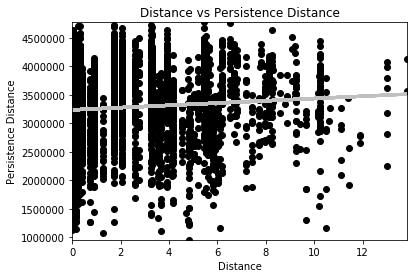

In [17]:
regress(df.as_matrix(columns=['cross_entropy']), df.as_matrix(columns=['per_distance']), 'Distance', 'Persistence Distance')